In [1]:
import pandas as pd
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
import numpy as np
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import metrics

from nltk.tokenize import word_tokenize
from nltk import pos_tag

from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

import matplotlib.patches as mpatches


In [16]:
%matplotlib inline

### <span style="font-family:lucida;color:#26004d">Data Preparation</span>

### <span style="font-family:lucida;color:#512da8">Text Preprocessing ( Stopwords removal, word stemming )</span>

In [7]:
stopwords_list = stopwords.words( 'english')

stemmer = PorterStemmer()

### <span style="font-family:lucida;color:#512da8">This transform function is used to preprocess the data at the time of reading the file itself. This is much more effieicnt than doing the preprocessing after reading the entire file</span>m

In [29]:
def transform( val ):
    val = re.sub( "^b[\"\']|[\"\']", "", str( val ).lower() )
    val_new = ""
    for word in re.split( "[\t\s]+", val ):
        stemmed_word = stemmer.stem( word )
        if stemmed_word in stopwords_list: continue
        val_new = val_new + " " + stemmed_word
    return val_new

### <span style="font-family:lucida;color:#512da8">Create a map of column id and converter function which will get applied to that col</span>

In [31]:
c = {}
for i in range( 2, 27 ):
    c[i] = lambda x : transform( x )

In [35]:
df = pd.read_csv( "/home/brij/smu/MachineLearning/tmp/NewsToMarket/data/Combined_News_DJIA.csv", sep=",", converters=c )

### <span style="font-family:lucida;color:#512da8">Create another field with combined news for each day</span>

In [37]:
df['combined_news'] = df.apply( lambda row: " ".join( map( lambda x: str(x), row[2:] ) ), axis=1 )

### <span style="font-family:lucida;color:#512da8">Write this cleaned data on disk, so that next time we dont have to preprocess</span>

In [39]:
df.to_csv( "/home/brij/smu/MachineLearning/project/NewsToMarket/data/cleaned_combined_News_DJIA.csv", sep=",", doublequote=True, index=False )

### <span style="font-family:lucida;color:#512da8">Read the cleaned data</span>

In [3]:
df2 = pd.read_csv( "/home/brij/smu/MachineLearning/project/NewsToMarket/data/cleaned_combined_News_DJIA.csv", sep="," )

### <span style="font-family:lucida;color:#512da8">Tokenize senetences and store the word vector in the dataframe</span>

In [9]:
word_tokens = df2['combined_news'].apply( lambda x: word_tokenize( x ) )
df2['word_tokens'] = word_tokens

## <span style="font-family:lucida;color:#26004d">Exploratory Analysis</span>

### <span style="font-family:lucida;color:#512da8">Word counts for each day</span>

In [11]:
df2['word_count'] = df2['combined_news'].apply( lambda x: len( re.split( "[\t\s]+", x.strip( "\n" ) )))

### <span style="font-family:lucida;color:#512da8">Function to calculate Word cloud and plot</span>

In [25]:
def draw_cloud( x ):
    plt.figure( figsize=(10, 10))
    plt.title( "Prominent noun phrases words" )
    cloud = WordCloud( width=720, height=500 ).generate( " ".join( x[0] ) )
    
    plt.subplot(1,2,1)
    plt.imshow( cloud )
    plt.title( "Market Up" )
    
    cloud = WordCloud( width=720, height=500 ).generate( " ".join( x[1] ) )
    plt.subplot(1,2,2)
    plt.imshow( cloud )
    
    plt.title( "Market Down" )
    plt.show()


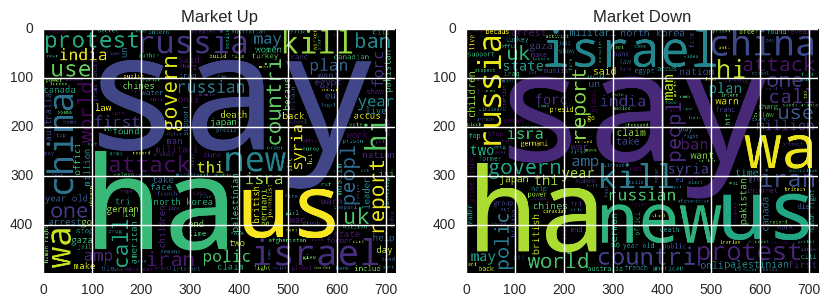

In [26]:
draw_cloud( ( df2[df2['Label']==1]['combined_news'], df2[df2['Label']==0]['combined_news'] ) )


#### <span style="font-family:lucida;color:#5e35b1">Word cloud does'nt show any peculiar words when market is up or down</span>

/home/brij/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


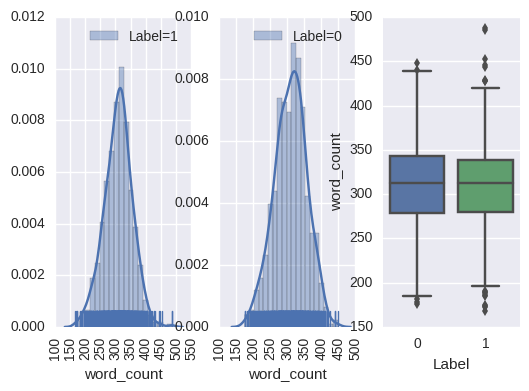

In [46]:
plt.subplot( 1,3,1)
sns.distplot( df2[(df2.Label==1)]['word_count'], bins=20, hist=True, kde=True, rug=True, norm_hist=True, label="Label=1"   ) 
plt.xticks( rotation='vertical')
plt.legend()
plt.subplot(1, 3, 2)
sns.distplot( df2[(df2.Label==0)]['word_count'], bins=20, hist=True, kde=True, rug=True, norm_hist=True, label="Label=0"   ) 
plt.legend()
plt.xticks( rotation='vertical')

plt.subplot(1, 3, 3)
sns.boxplot( x='Label', y='word_count', data=df2)
plt.show()

#### <span style="font-family:lucida;color:#5e35b1">Distribution of the words are almost normal with a slight right skew when the market is up</span>

### <span style="font-family:lucida;color:#512da8">Lets check the distribution of shared words each day</span>

In [43]:
df2['shared_word_count'] = df2['combined_news'].apply( lambda x : np.count_nonzero( pd.Series( re.split( "[\t\s]+", x ) )
                                                            .value_counts().values != 1 ))

/home/brij/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


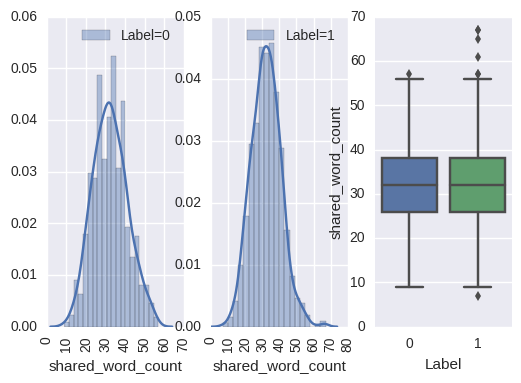

In [45]:
plt.subplot( 1, 3, 1)
sns.distplot( df2[(df2.Label==0)]['shared_word_count'], bins=20, kde=True, hist=True, norm_hist=True, label="Label=0" )
plt.xticks( rotation='vertical' )
plt.legend()

plt.subplot( 1, 3, 2)
sns.distplot( df2[(df2.Label==1)]['shared_word_count'], bins=20, kde=True, hist=True, norm_hist=True, label="Label=1" )
plt.xticks( rotation='vertical' )
plt.legend()

plt.subplot( 1, 3, 3)
sns.boxplot( x='Label', y='shared_word_count', data=df2)

plt.show()

#### <span style="font-family:lucida;color:#5e35b1">Similar to word count distribution a slight right skew can be observed when market is up</span>

### <span style="font-family:lucida;color:#512da8">Lets split the data into train and test set</span>

In [27]:
train = df2[df2['Date']<'2016-01-01'].index
test = df2[df2['Date']>'2015-12-31'].index

In [28]:
x_train = df2['combined_news'].iloc[train]
x_test = df2['combined_news'].iloc[test]

y_train = df2['Label'].iloc[train]
y_test = df2['Label'].iloc[test]

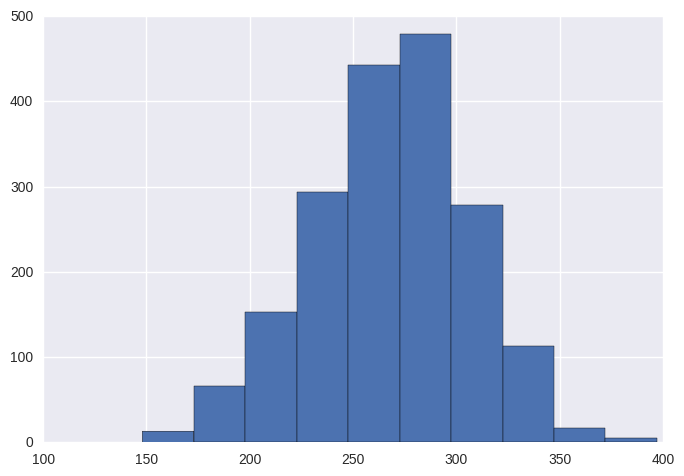

In [10]:
unique_words_train = df2['word_tokens'][train].apply( lambda x : np.unique( x ).shape[0] )
unique_words_train.hist()
plt.show()

#### <span style="font-family:lucida;color:#5e35b1">Distribution of unique word counts across all the news articles in the training set</span>

## <span style="font-family:lucida;color:#26004d">Data Representation</span>

### <span style="font-family:lucida;color:#512da8">Lets convert the news data into BOW representation</span>

In [47]:

vectorizer = CountVectorizer( ngram_range=(1,1), min_df = 0.001, max_df = 0.5)#,stop_words='english' )
vectorizer_2 = CountVectorizer( ngram_range=(2,2), min_df=0.001, max_df = 0.5)#, stop_words='english' )


In [48]:
x_train_bow = vectorizer.fit_transform( x_train )
x_test_bow = vectorizer.transform( x_test )

x_train_bow_2 = vectorizer_2.fit_transform( x_train )
x_test_bow_2 = vectorizer_2.transform( x_test )


## <span style="font-family:lucida;color:#26004d">Model Fitting</span>

### <span style="font-family:lucida;color:#512da8">Based on multiple runs, we got below parameters</span>

In [50]:
Classifiers = [
    LogisticRegression(C=0.000001,solver='liblinear',max_iter=200),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=250, oob_score=True),
    BaggingClassifier(),
    AdaBoostClassifier( DecisionTreeClassifier(max_depth = 2), n_estimators = 10, algorithm ='SAMME.R', random_state = 2017 ),
    GaussianNB(),
    MultinomialNB()]


In [67]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')


In [77]:
def print_confusion( y_test, pred ):
    plt.subplot( 1,2,1)
    labels = [ "Up", "Down" ]
    cm = metrics.confusion_matrix(y_test, pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [95]:

def run_model( x_train, y_train, x_test, y_test ):
    plt.figure( figsize=(8,8))
    Accuracy=[]
    Model=[]
    F1=[]
    Precision=[]
    Recall=[]
    lw = 2
    patches = []
    for classifier in Classifiers:
        i = 1
        try:
            fit = classifier.fit( x_train, y_train)
            y_pred = fit.predict( x_test )
        except:
            fit = classifier.fit( x_train.toarray(), y_train)
            y_pred = fit.predict( x_test.toarray() )

        Accuracy.append( metrics.accuracy_score( y_test, y_pred ) )
        F1.append( metrics.f1_score( y_test, y_pred ) )
        Precision.append( metrics.precision_score( y_test, y_pred ) )
        Recall.append( metrics.recall_score( y_test, y_pred ) )
        Model.append( classifier.__class__.__name__ )
        
        #print( metrics.confusion_matrix( y_test, y_pred ) )
        
        fpr, tpr, _ = roc_curve( y_test, y_pred )

        cl = np.random.rand(3,1)
        plt.subplot(1,1,1)
        plt.plot( fpr, tpr, label=classifier.__class__.__name__, c=cl)
        i += 1
        patches.append( mpatches.Patch( color=cl, label=str( classifier.__class__.__name__ ) + " : " + 
                                                               str( metrics.accuracy_score( y_test, y_pred ) )))
    
    m = pd.DataFrame( list( zip( Model, Accuracy, F1, Precision, Recall ) ), columns=['Model','Accuracy', 'F1', 'Precision','Recall'] )
    print_full( m )
    plt.legend( loc='best' )
    plt.legend(  handles=patches, loc='best')
    plt.plot( [ 0,1],[0,1], color='navy', lw=lw, linestyle='--')
    plt.show()
    #  print( metrics.confusion_matrix( y_test, y_pred ) )


### <span style="font-family:lucida;color:#512da8">Running model with ngram = 1, count representation </span>

                    Model  Accuracy        F1  Precision    Recall
0      LogisticRegression  0.551181  0.710660   0.551181  1.000000
1    KNeighborsClassifier  0.511811  0.651685   0.537037  0.828571
2  DecisionTreeClassifier  0.511811  0.581081   0.551282  0.614286
3  RandomForestClassifier  0.535433  0.650888   0.555556  0.785714
4       BaggingClassifier  0.488189  0.539007   0.535211  0.542857
5      AdaBoostClassifier  0.590551  0.686747   0.593750  0.814286
6              GaussianNB  0.464567  0.476923   0.516667  0.442857
7           MultinomialNB  0.464567  0.552632   0.512195  0.600000


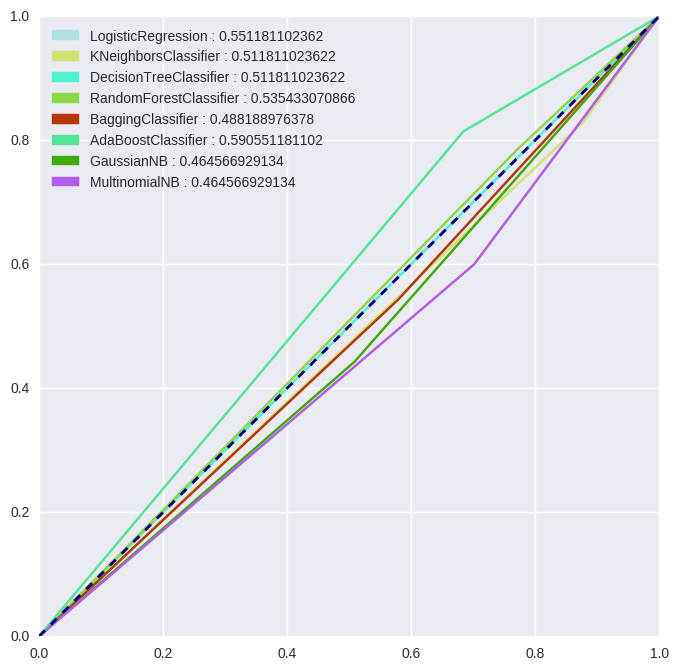

In [96]:
run_model( x_train_bow, y_train, x_test_bow, y_test )

### <span style="font-family:lucida;color:#512da8">Running model with ngram = 2, count representation </span>

                    Model  Accuracy        F1  Precision    Recall
0      LogisticRegression  0.551181  0.710660   0.551181  1.000000
1    KNeighborsClassifier  0.480315  0.297872   0.583333  0.200000
2  DecisionTreeClassifier  0.496063  0.561644   0.539474  0.585714
3  RandomForestClassifier  0.535433  0.691099   0.545455  0.942857
4       BaggingClassifier  0.496063  0.589744   0.534884  0.657143
5      AdaBoostClassifier  0.582677  0.713514   0.573913  0.942857
6              GaussianNB  0.519685  0.579310   0.560000  0.600000
7           MultinomialNB  0.559055  0.621622   0.589744  0.657143


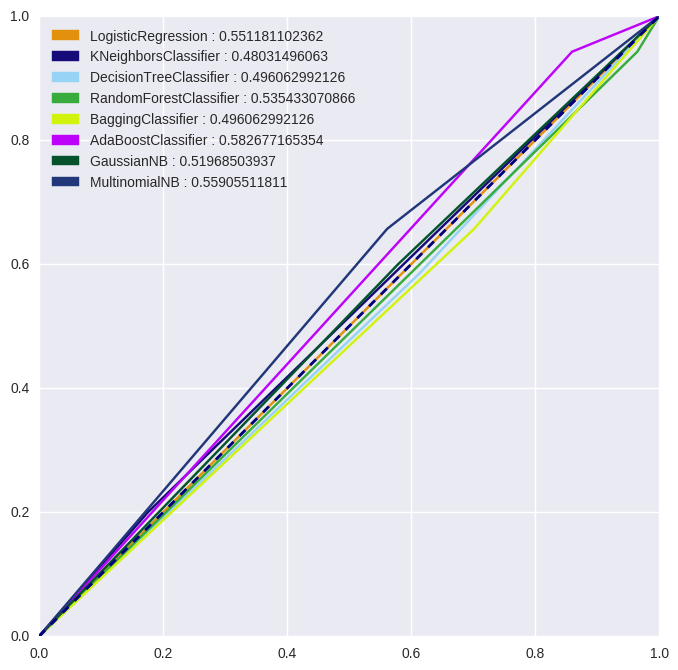

In [98]:
run_model( x_train_bow_2, y_train, x_test_bow_2, y_test )

#### <span style="font-family:lucida;color:#5e35b1">With only count representation, we see superior accuracy for ngram = 2 at an accuracy of 55.9% with MNB</span>

### <span style="font-family:lucida;color:#512da8">To further see, if tfidf weighting adds any value to the model; lets use tfidf weighting  </span>

### <span style="font-family:lucida;color:#512da8">tfidf is applied for both ngram = 1 and 2 and will be used for model fitting </span>

In [101]:
tfidf_vectorizer = TfidfVectorizer( ngram_range=(1,1), norm='l2', min_df=0.001, max_df=0.5,stop_words='english'  )
tfidf_vectorizer_2 = TfidfVectorizer( ngram_range=(2,2), norm='l2',min_df=0.001, max_df=0.5, stop_words='english' )

In [102]:
x_train_tfidf = tfidf_vectorizer.fit_transform( x_train )
x_test_tfidf = tfidf_vectorizer.transform( x_test )

x_train_tfidf_2 = tfidf_vectorizer_2.fit_transform( x_train )
x_test_tfidf_2 = tfidf_vectorizer_2.transform( x_test )


In [105]:
dense_train_tfidf_2 = x_train_tfidf_2.toarray()

In [106]:
feature_vector = np.array( tfidf_vectorizer_2.get_feature_names() )

### <span style="font-family:lucida;color:#512da8">Lets look at the word cloud of the tfidf weighted words when the marketis up and down</span>

/home/brij/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':
/home/brij/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


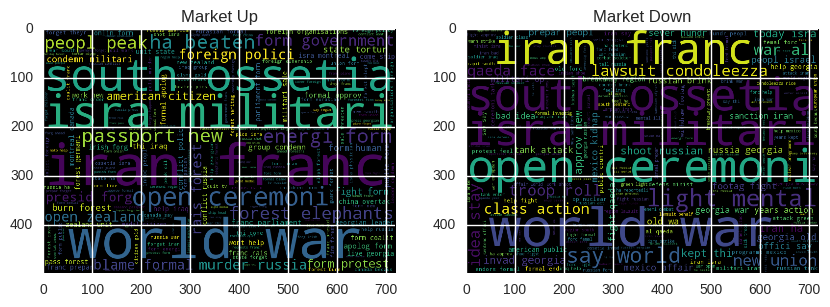

In [108]:
aaa = np.apply_along_axis( lambda x : np.argsort( x )[::-1], 1, dense_train_tfidf_2[[y_train==1]] )
aa1 = np.apply_along_axis( lambda x: " ".join( feature_vector[x[:100]] ), 1, aaa )

aaa = np.apply_along_axis( lambda x : np.argsort( x )[::-1], 1, dense_train_tfidf_2[[y_train==0]] )
aa2 = np.apply_along_axis( lambda x: " ".join( feature_vector[x[:100]] ), 1, aaa )

draw_cloud( ( aa1, aa2 ) )

### <span style="font-family:lucida;color:#512da8">Lets run the model with tfidf representation on both ngram=1 and ngram=2 </span>

                    Model  Accuracy        F1  Precision    Recall
0      LogisticRegression  0.551181  0.710660   0.551181  1.000000
1    KNeighborsClassifier  0.464567  0.507246   0.514706  0.500000
2  DecisionTreeClassifier  0.464567  0.527778   0.513514  0.542857
3  RandomForestClassifier  0.551181  0.670520   0.563107  0.828571
4       BaggingClassifier  0.559055  0.575758   0.612903  0.542857
5      AdaBoostClassifier  0.551181  0.528926   0.627451  0.457143
6              GaussianNB  0.496063  0.536232   0.544118  0.528571
7           MultinomialNB  0.551181  0.710660   0.551181  1.000000


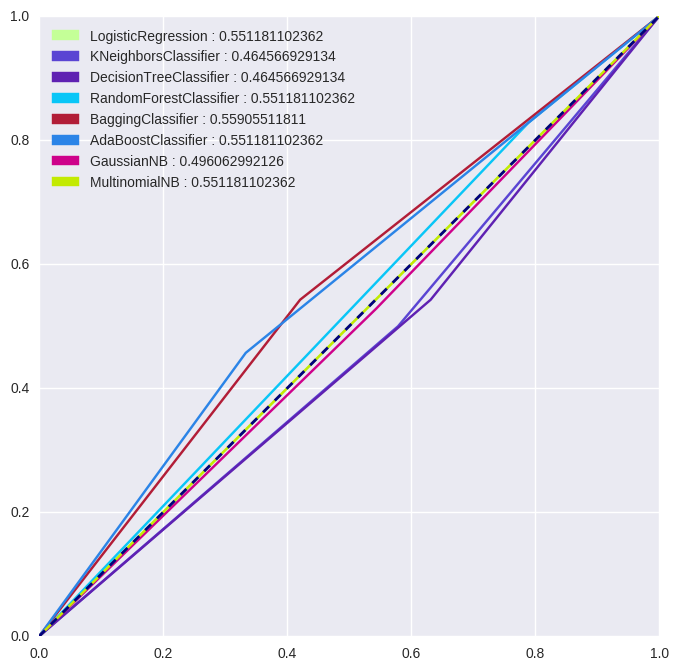

In [110]:
###run for ngram = 1
run_model( x_train_tfidf, y_train, x_test_tfidf, y_test )

                    Model  Accuracy        F1  Precision    Recall
0      LogisticRegression  0.551181  0.710660   0.551181  1.000000
1    KNeighborsClassifier  0.527559  0.583333   0.567568  0.600000
2  DecisionTreeClassifier  0.566929  0.580153   0.622951  0.542857
3  RandomForestClassifier  0.472441  0.537931   0.520000  0.557143
4       BaggingClassifier  0.496063  0.492063   0.553571  0.442857
5      AdaBoostClassifier  0.590551  0.711111   0.581818  0.914286
6              GaussianNB  0.503937  0.588235   0.542169  0.642857
7           MultinomialNB  0.527559  0.677419   0.543103  0.900000


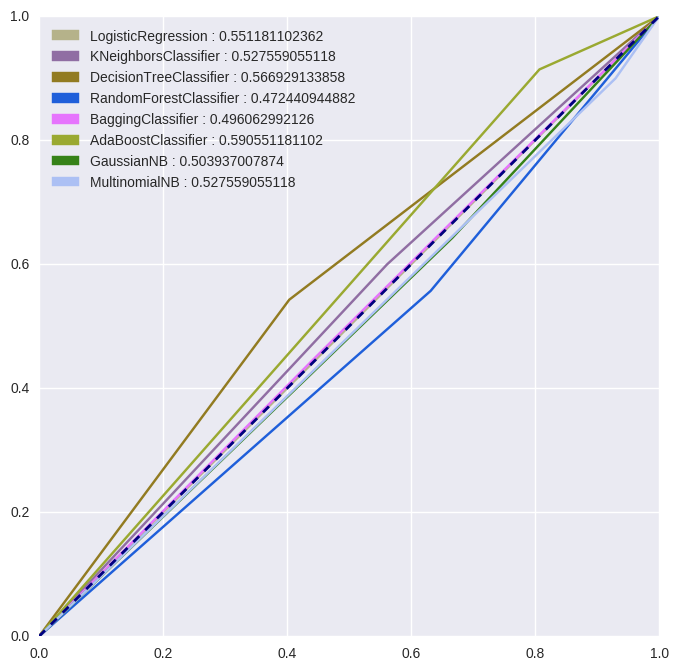

In [111]:
## run for ngram = 2
run_model( x_train_tfidf_2, y_train, x_test_tfidf_2, y_test )

#### <span style="color:green">Overall we see, ngram=2 is a better representation for this problem. It is giving better results both with CountVectorizer as well as tfidf</span>

### <span style="color:red;font-style:italic">Some of the researches has claimed that models fitted with only noun phrases gives far better accuracy than with using all words combined. Lets try to fit the model with only noun phrases</span>


## <span style="font-family:lucida;color:#26004d">Semantic Analysis</span>

### <span style="font-family:lucida;color:#512da8">NLTK POS tagger is used here to identify different tags</span>

In [112]:
word_tokens_tagged = word_tokens.apply( lambda x : pos_tag( x ) )

In [115]:
pos_holder = []
for i, items in enumerate( word_tokens_tagged ):
    t = ""
    for word_tuple in items:
        if word_tuple[1] == 'NN':   ##retain only the noun phrases
            t += " " + str( word_tuple[0] )
    t = re.sub( "^[\t\s]*", "", t )
    pos_holder.append( t )
pos_holder = np.array( pos_holder )


In [116]:
b = []
for r in pos_holder:
    splitted_r = r.split( " " )
    b.append( splitted_r )

In [117]:
aaa = pd.Series( np.concatenate( b ) ).value_counts()

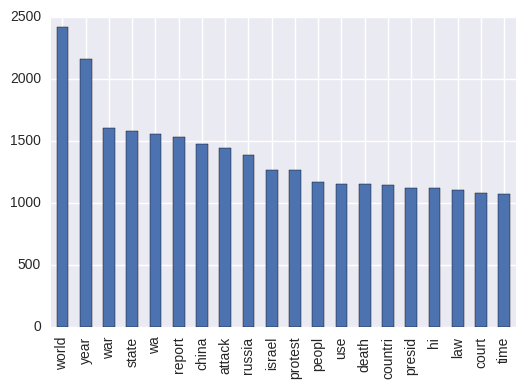

In [120]:
aaa[1:].head(20).plot( kind='bar' )
plt.show()

#### <span style="font-family:lucida;color:#5e35b1">Above is the bar plot of top 20 words after POS tagging </span>

In [123]:
def draw_cloud( x ):
    cloud = WordCloud( width=1440, height=1080 ).generate( " ".join( x ) )
    plt.figure( figsize=(8, 8))
    plt.title( "Prominent noun phrases words" )
    plt.imshow( cloud )
    plt.show()


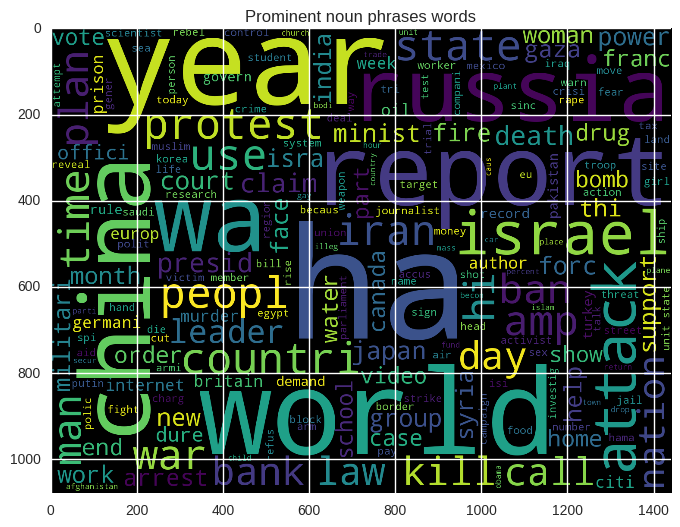

In [124]:
draw_cloud( pos_holder )


### <span style="font-family:lucida;color:#512da8">The noun words indetified are further represented as tfidf weighted BOW for model fitting and analysis</span>

In [125]:
x_train_nn_tfidf = tfidf_vectorizer.fit_transform( pos_holder[train] )
x_test_nn_tfidf = tfidf_vectorizer.transform( pos_holder[test] )

x_train_nn_tfidf_2 = tfidf_vectorizer_2.fit_transform( pos_holder[train] )
x_test_nn_tfidf_2 = tfidf_vectorizer_2.transform( pos_holder[test] )


                    Model  Accuracy        F1  Precision    Recall
0      LogisticRegression  0.551181  0.710660   0.551181  1.000000
1    KNeighborsClassifier  0.527559  0.577465   0.569444  0.585714
2  DecisionTreeClassifier  0.496063  0.522388   0.546875  0.500000
3  RandomForestClassifier  0.582677  0.666667   0.595506  0.757143
4       BaggingClassifier  0.519685  0.469565   0.600000  0.385714
5      AdaBoostClassifier  0.503937  0.519084   0.557377  0.485714
6              GaussianNB  0.535433  0.562963   0.584615  0.542857
7           MultinomialNB  0.574803  0.721649   0.564516  1.000000


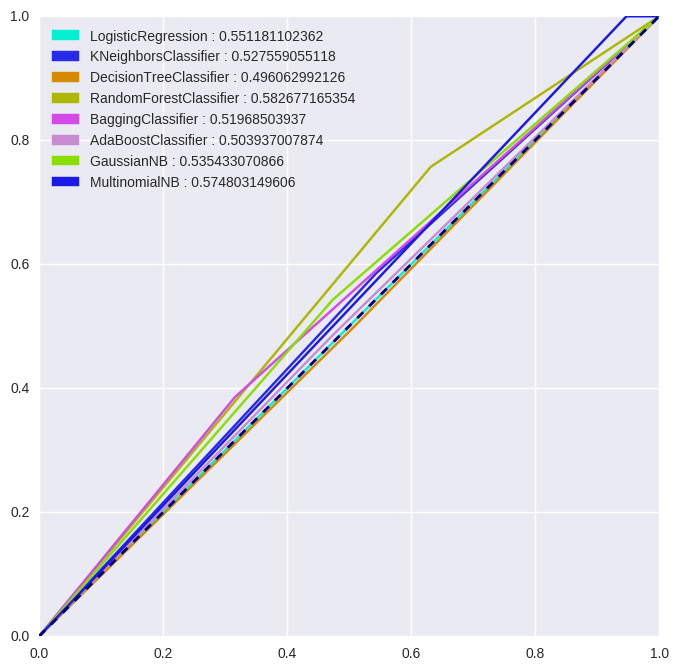

In [127]:
###Running model for ngram = 1, with tfidf representation
run_model( x_train_nn_tfidf, y_train, x_test_nn_tfidf, y_test )


                    Model  Accuracy        F1  Precision    Recall
0      LogisticRegression  0.551181  0.710660   0.551181  1.000000
1    KNeighborsClassifier  0.440945  0.489209   0.492754  0.485714
2  DecisionTreeClassifier  0.519685  0.487395   0.591837  0.414286
3  RandomForestClassifier  0.622047  0.707317   0.617021  0.828571
4       BaggingClassifier  0.472441  0.488550   0.524590  0.457143
5      AdaBoostClassifier  0.559055  0.705263   0.558333  0.957143
6              GaussianNB  0.527559  0.610390   0.559524  0.671429
7           MultinomialNB  0.590551  0.694118   0.590000  0.842857


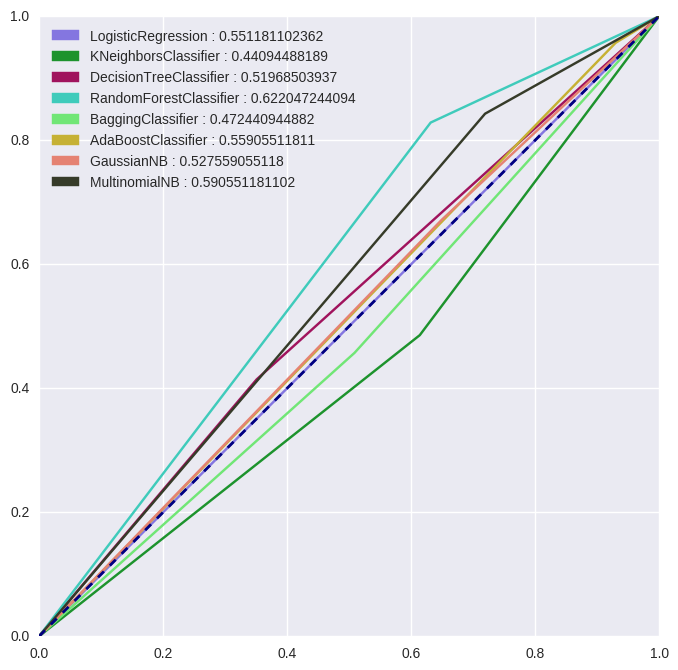

In [128]:
###Running model for ngram = 2, with tfidf representation
run_model( x_train_nn_tfidf_2, y_train, x_test_nn_tfidf_2, y_test )

#### <span style="font-family:lucida;color:#5e35b1">Model using this reduced dataset does improve the model accuracy tfidf and ngam = 2. RandomForest shows the best performance at 62.2% </span>

## <span style="font-family:lucida;color:#26004d">Sentiment Analysis</span>

### <span style="font-family:lucida;color:#512da8">Sentiment can have a driivng impact on market; lets see if including sentiment in the model improves teh accuracy in any manner</span>

### <span style="font-family:lucida;color:#512da8">A precompiled lexicon of positive and negative words is used here to identify the net sentiment for each day </span>

In [132]:
lex_df = pd.read_csv( "/home/brij/smu/MachineLearning/project/NewsToMarket/data/lexicons_compiled.csv", sep=",", header=None, skiprows=1 )

### <span style="font-family:lucida;color:#512da8">A postitive and negative score is calculated </span>

In [133]:
def get_sentiment_score( doc ):
    pos = 0
    neg = 0
    neu = 0
    for w in doc:
        isneu = 0
        if (lex_df[ lex_df[0] == w ][4] == 'positive' ).any():
            pos += 1
            isneu = 1
        if (lex_df[ lex_df[0] == w ][4] == 'negative' ).any():
            neg += 1
            isneu = 1
        
        if isneu == 0 : neu += 1
    t = pos + neg + neu 
    return( ( pos/t, neg/t ) )


In [134]:
ss = pd.Series( word_tokens ).apply( lambda x: get_sentiment_score( x )  )
df2['positive'] = pd.Series( [ i[0] for i in ss ])
df2['negative'] = pd.Series( [ i[1] for i in ss ])


### <span style="font-family:lucida;color:#512da8">A net sentiment score is calcultaed as diff between postive and negative  score is calculated </span>

In [135]:
net_sentiment = df2[ 'positive'] - df2['negative']

### <span style="font-family:lucida;color:#512da8">Ditribution of the net sentiment seems pretty normal</span>

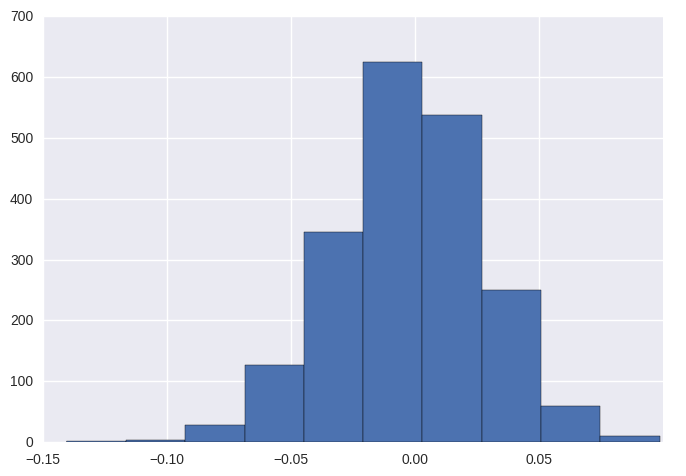

In [44]:
plt.hist( net_sentiment )
plt.show()


### <span style="font-family:lucida;color:#512da8">It would be interesting to see the distribution of teh sentimemt score when the market is up and down</span>

/home/brij/anaconda3/lib/python3.5/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


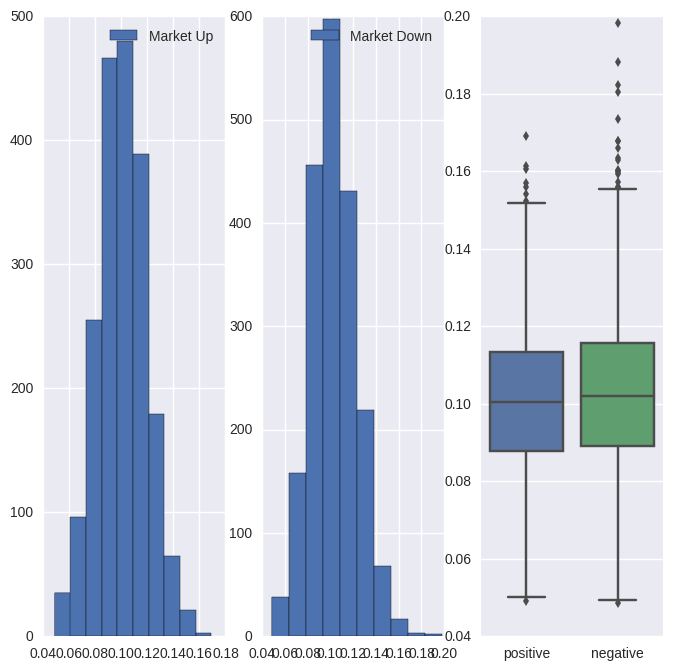

In [138]:
plt.figure( figsize=( 8, 8 ) )
plt.subplot( 1,3,1)
plt.hist( df2['positive'], label="Market Up" )
plt.legend( loc = 'best')
plt.subplot( 1,3,2)

plt.hist( df2['negative'], label="Market Down" )
plt.legend( loc = 'best')

plt.subplot( 1,3,3)
sns.boxplot( df2[['positive','negative']] )
plt.show()


In [139]:
c = pd.melt( df2, id_vars=['Label'], value_vars=[ 'positive', 'negative'], var_name='sentiment_label', value_name='sentiment_score' )

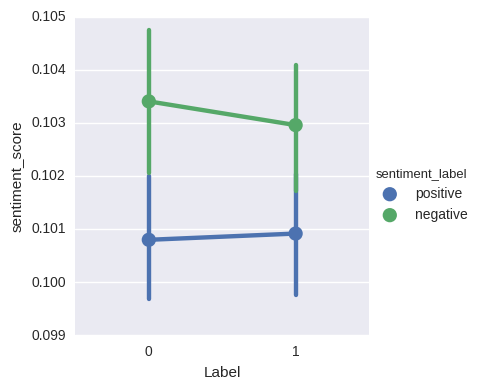

In [140]:
sns.factorplot( x ="Label", y = "sentiment_score", hue='sentiment_label', data=c,kind="point" )
plt.show()


#### <span style="color:green">This seems very interesting. We see a net reduction in the negative sentiment when the market is up and vice versa</span>

In [43]:
from scipy.sparse import csr_matrix
x_train_s = csr_matrix( net_sentiment[train] )
x_test_s = csr_matrix( net_sentiment[test] )


In [147]:
Classifiers = [
    LogisticRegression(C=0.000001,solver='liblinear',max_iter=200),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=250, oob_score=True),
    BaggingClassifier(),
    AdaBoostClassifier( DecisionTreeClassifier(max_depth = 2), n_estimators = 10, algorithm ='SAMME.R', random_state = 2017 )]


In [148]:
def run_model_2( x_train, y_train, x_test, y_test ):
    i = 1
    Accuracy=[]
    Model=[]
    F1=[]
    Precision=[]
    Recall=[]
    patches = []
    lw =2 
    for classifier in Classifiers:
        fit = classifier.fit( x_train, y_train)
        y_pred = fit.predict( x_test )

        Accuracy.append( metrics.accuracy_score( y_test, y_pred ) )
        F1.append( metrics.f1_score( y_test, y_pred ) )
        Precision.append( metrics.precision_score( y_test, y_pred ) )
        Recall.append( metrics.recall_score( y_test, y_pred ) )
        Model.append( classifier.__class__.__name__ )
        #print( metrics.confusion_matrix( y_test, y_pred ) )
        
        fpr, tpr, _ = roc_curve( y_test, y_pred )
        #plt.subplot( 2, 4, i )
        cl = np.random.rand(3,1)
        plt.plot( fpr, tpr, label=classifier.__class__.__name__, c=cl)
        i += 1
        patches.append( mpatches.Patch( color=cl, label=str( classifier.__class__.__name__ ) + " : " + 
                                                               str( metrics.accuracy_score( y_test, y_pred ) )))
    
    m = pd.DataFrame( list( zip( Model, Accuracy, F1, Precision, Recall ) ), columns=['Model','Accuracy', 'F1', 'Precision','Recall'] )
    print_full( m )
    plt.legend( loc='best' )
    plt.legend(  handles=patches, loc='best')
    plt.plot( [ 0,1],[0,1], color='navy', lw=lw, linestyle='--')
    plt.show()
    #  print( metrics.confusion_matrix( y_test, y_pred ) )


### <span style="font-family:lucida;color:#512da8">Exploratory analysis using sentiment does reveal a distinct trend on the market and therfore it could be a big feature in predicting the market. We want to analyze this by fitting teh model using only the sentiment score and then comparing the score </span> 

                    Model  Accuracy        F1  Precision    Recall
0      LogisticRegression  0.551181  0.710660   0.551181  1.000000
1    KNeighborsClassifier  0.464567  0.534247   0.513158  0.557143
2  DecisionTreeClassifier  0.503937  0.533333   0.553846  0.514286
3  RandomForestClassifier  0.488189  0.532374   0.536232  0.528571
4       BaggingClassifier  0.464567  0.500000   0.515152  0.485714
5      AdaBoostClassifier  0.527559  0.659091   0.547170  0.828571


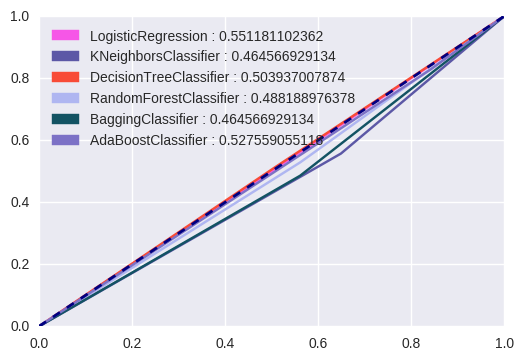

In [149]:
###Running model for ngram = 2, with tfidf representation
run_model_2( net_sentiment[train][:,np.newaxis], y_train, net_sentiment[test][:,np.newaxis], y_test )


#### <span style="color:green">Using only the sentiment score doesnt show a very good score in predicting the market</span>

### <span style="font-family:lucida;color:#512da8">Since sentiment score could easily be ignore in the very high dimensional BOW representation; to force the model to use this we can weigh the seentimenet score before using it along with the tfidf </span>

W =  1
                    Model  Accuracy        F1  Precision    Recall
0      LogisticRegression  0.551181  0.710660   0.551181  1.000000
1    KNeighborsClassifier  0.535433  0.581560   0.577465  0.585714
2  DecisionTreeClassifier  0.598425  0.578512   0.686275  0.500000
3  RandomForestClassifier  0.464567  0.546667   0.512500  0.585714
4       BaggingClassifier  0.480315  0.431034   0.543478  0.357143
5      AdaBoostClassifier  0.598425  0.715084   0.587156  0.914286


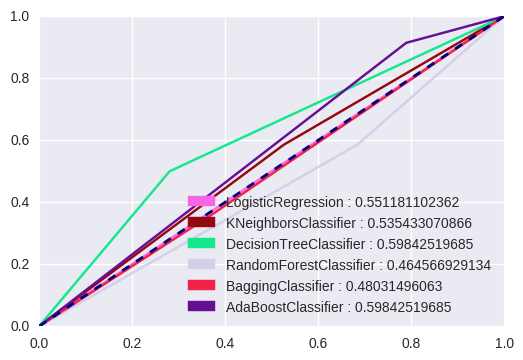

W =  10
                    Model  Accuracy        F1  Precision    Recall
0      LogisticRegression  0.551181  0.710660   0.551181  1.000000
1    KNeighborsClassifier  0.425197  0.482270   0.478873  0.485714
2  DecisionTreeClassifier  0.582677  0.576000   0.654545  0.514286
3  RandomForestClassifier  0.527559  0.605263   0.560976  0.657143
4       BaggingClassifier  0.480315  0.492308   0.533333  0.457143
5      AdaBoostClassifier  0.598425  0.715084   0.587156  0.914286


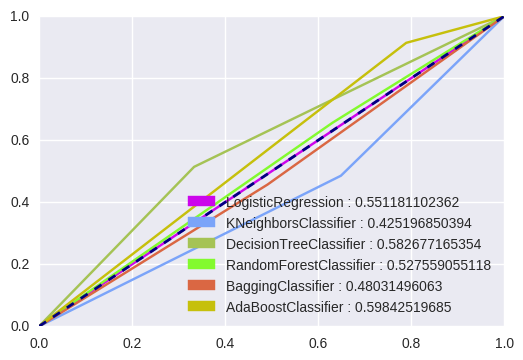

W =  100
                    Model  Accuracy        F1  Precision    Recall
0      LogisticRegression  0.566929  0.712042   0.561983  0.971429
1    KNeighborsClassifier  0.535433  0.587413   0.575342  0.600000
2  DecisionTreeClassifier  0.582677  0.554622   0.673469  0.471429
3  RandomForestClassifier  0.448819  0.533333   0.500000  0.571429
4       BaggingClassifier  0.527559  0.538462   0.583333  0.500000
5      AdaBoostClassifier  0.598425  0.715084   0.587156  0.914286


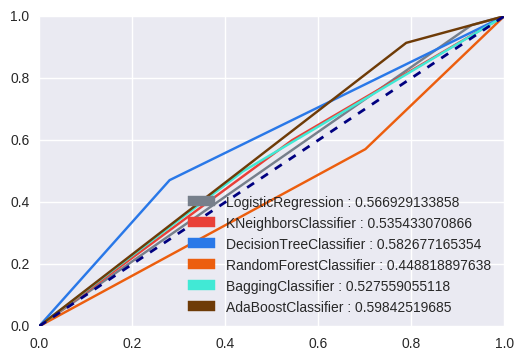

W =  1000
                    Model  Accuracy        F1  Precision    Recall
0      LogisticRegression  0.464567  0.500000   0.515152  0.485714
1    KNeighborsClassifier  0.433071  0.500000   0.486486  0.514286
2  DecisionTreeClassifier  0.574803  0.550000   0.660000  0.471429
3  RandomForestClassifier  0.503937  0.593548   0.541176  0.657143
4       BaggingClassifier  0.503937  0.503937   0.561404  0.457143
5      AdaBoostClassifier  0.598425  0.715084   0.587156  0.914286


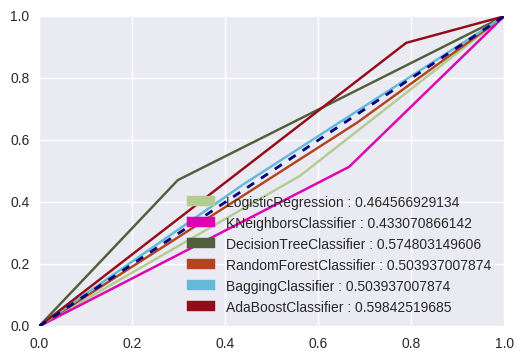

W =  10000
                    Model  Accuracy        F1  Precision    Recall
0      LogisticRegression  0.464567  0.500000   0.515152  0.485714
1    KNeighborsClassifier  0.448819  0.513889   0.500000  0.528571
2  DecisionTreeClassifier  0.598425  0.598425   0.666667  0.542857
3  RandomForestClassifier  0.488189  0.563758   0.531646  0.600000
4       BaggingClassifier  0.480315  0.400000   0.550000  0.314286
5      AdaBoostClassifier  0.598425  0.715084   0.587156  0.914286


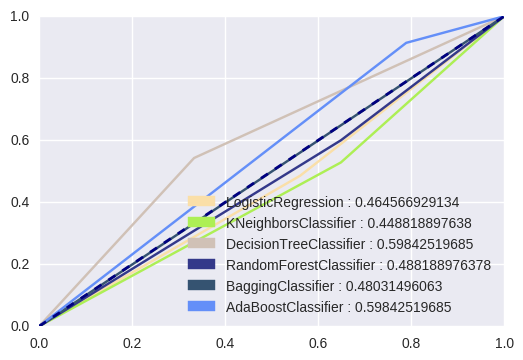

In [152]:
W = [ 1, 10, 100, 1000, 10000]
for w in W:
    print( "W = ", str( w ) )
    x_train_extended_2 = np.hstack( (x_train_tfidf_2.toarray(), w*net_sentiment[train][:,np.newaxis] ) )
    x_test_extended_2 = np.hstack( (x_test_tfidf_2.toarray(), w*net_sentiment[test][:,np.newaxis]) )
    run_model_2( x_train_extended_2, y_train, x_test_extended_2, y_test )                    

### <span style="font-family:lucida;color:#512da8">Plotting the Accuracy and F1 score for different models and weights. The weights and accuracy in the arrays below was manually popuated from above values </span>

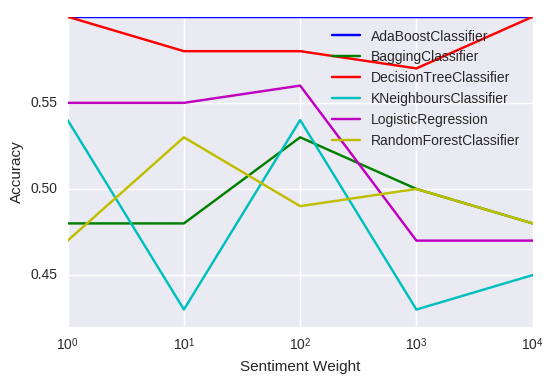

In [153]:
w = [ 1, 10, 100, 1000, 10000 ]
ada_accuracy = [ 0.6, 0.6, 0.6, 0.6, 0.6 ]
bagg_accuracy = [ 0.48, 0.48, 0.53, 0.5, 0.48 ]
decisiontree_accuracy = [ 0.6, 0.58, 0.58, 0.57, 0.6 ]
kn_accuracy = [ 0.54, 0.43, 0.54, 0.43, 0.45 ]
logistic_accuracy = [ 0.55, 0.55, 0.56, 0.47, 0.47 ]
random_forest_accuracy = [ 0.47, 0.53, 0.49, 0.5, 0.48 ]
plt.plot( w, ada_accuracy,c='b',label='AdaBoostClassifier')
plt.plot(w, bagg_accuracy,c='g', label='BaggingClassifier')
plt.plot(w, decisiontree_accuracy,c='r', label='DecisionTreeClassifier')
plt.plot(w, kn_accuracy,c='c', label='KNeighboursClassifier')
plt.plot(w, logistic_accuracy,c='m', label='LogisticRegression')
plt.plot(w, random_forest_accuracy,c='y', label='RandomForestClassifier')
plt.xscale('log')
plt.xlabel( "Sentiment Weight" )
plt.ylabel( "Accuracy")
plt.legend()
plt.show()

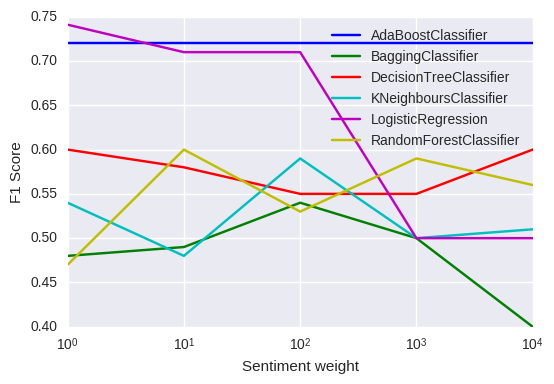

In [157]:
w = [ 1, 10, 100, 1000, 10000 ]
ada_f1 = [ 0.72, 0.72, 0.72, 0.72, 0.72 ]
bagg_f1 = [ 0.48, 0.49, 0.54, 0.5, 0.4 ]
decisiontree_f1 = [ 0.6, 0.58, 0.55, 0.55, 0.6]
kn_f1 = [ 0.54, 0.48, 0.59, 0.5, 0.51 ]
logistic_f1 = [ 0.741, 0.71, 0.71, 0.5, 0.5 ]
random_forest_f1 = [ 0.47, 0.6, 0.53, 0.59, 0.56 ]
plt.plot( w, ada_f1,c='b',label='AdaBoostClassifier')
plt.plot(w, bagg_f1,c='g', label='BaggingClassifier')
plt.plot(w, decisiontree_f1,c='r', label='DecisionTreeClassifier')
plt.plot(w, kn_f1,c='c', label='KNeighboursClassifier')
plt.plot(w, logistic_f1,c='m', label='LogisticRegression')
plt.plot(w, random_forest_f1,c='y', label='RandomForestClassifier')
plt.xscale('log')
plt.xlabel( "Sentiment weight")
plt.ylabel( "F1 Score")
plt.legend()
plt.show()

### <span style="font-family:lucida;color:#512da8">From above we see ada boost performing best in term sof accurcay and F1 score and invariant to w</span>